- Bibliotecas e configurações gerais do notebook

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 

from sklearn.metrics import roc_curve, precision_recall_curve, make_scorer, recall_score, confusion_matrix, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


rcParams['figure.figsize'] = (8, 8)
rcParams['figure.dpi'] = 150

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

- Funções utilizadas

In [15]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')


def conf_matrix(y_test, y_pred, model):   
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    return display.plot()
    

- Bibliotecas e configurações do pandas e matplotlib

In [4]:
df = pd.read_csv('training_data.csv', sep=';')
df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,25,Travel_Rarely,685,Research & Development,1,3,Life Sciences,1,350,1,Female,62,3,2,Manufacturing Director,3,Married,4898,7505,0,Y,No,12,3,4,80,2,5,3,3,4,2,1,2,0
1,44,Travel_Rarely,1376,Human Resources,1,2,Medical,1,1098,2,Male,91,2,3,Human Resources,1,Married,10482,2326,9,Y,No,14,3,4,80,1,24,1,3,20,6,3,6,1
2,27,Travel_Rarely,135,Research & Development,17,4,Life Sciences,1,1405,4,Female,51,3,1,Research Scientist,3,Single,2394,25681,1,Y,Yes,13,3,4,80,0,8,2,3,8,2,7,7,1
3,40,Travel_Frequently,580,Sales,5,4,Life Sciences,1,729,4,Male,48,2,3,Sales Executive,1,Married,10475,23772,5,Y,Yes,21,4,3,80,1,20,2,3,18,13,1,12,0
4,24,Travel_Rarely,477,Research & Development,24,3,Medical,1,1173,4,Male,49,3,1,Laboratory Technician,2,Single,3597,6409,8,Y,No,22,4,4,80,0,6,2,3,4,3,1,2,0


In [5]:
# transformando os dados para o padrão snake_case
def camel_to_snake(col: str) -> str:
    col = ''.join([item if not item.isupper() else '_' + item for item in col])
    return col[1:].lower()

for item in df.columns:
    df.rename(columns={item: camel_to_snake(item)}, inplace=True)
del camel_to_snake
    
df.business_travel.replace(r'_', ' ', regex=True, inplace=True)

- Primeiro foi feito um enconding na feature over_time

In [7]:
df['over_time'] = df['over_time'].replace({'Yes':1, 'No':0})

- Primeiro foram feitos testes com a variável target desbalanceada;
- Em seguida selecionou-se as 5 features mais correlacionadas com a feature target para trabalhar nos modelos;

In [8]:
cols = ['over_time', 'job_level', 'monthly_income', 'years_at_company', 'age', 'attrition']
df = df[cols]

In [141]:
# construção dos conjuntos de dados com as variáveis independentes (X) e a variável dependente (y)
X = df.drop('attrition', axis=1) 
y = df.attrition

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=51) # separação dos conjuntos de treino e teste

In [143]:
print('Training set shape: ', X_train.shape, y_train.shape)
print('Testing set shape: ', X_test.shape, y_test.shape)

Training set shape:  (882, 5) (882,)
Testing set shape:  (294, 5) (294,)


In [144]:
# escalonamento dos dados para testes com modelo KNN
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
scaler.fit(X_test)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

- Implementando o modelo KNN

In [145]:
model = KNeighborsClassifier()
model.fit(X_train_scaled, y_train) 

KNeighborsClassifier()

In [146]:
pred_train_knn = model.predict(X_train_scaled)
pred_test_knn = model.predict(X_test_scaled)

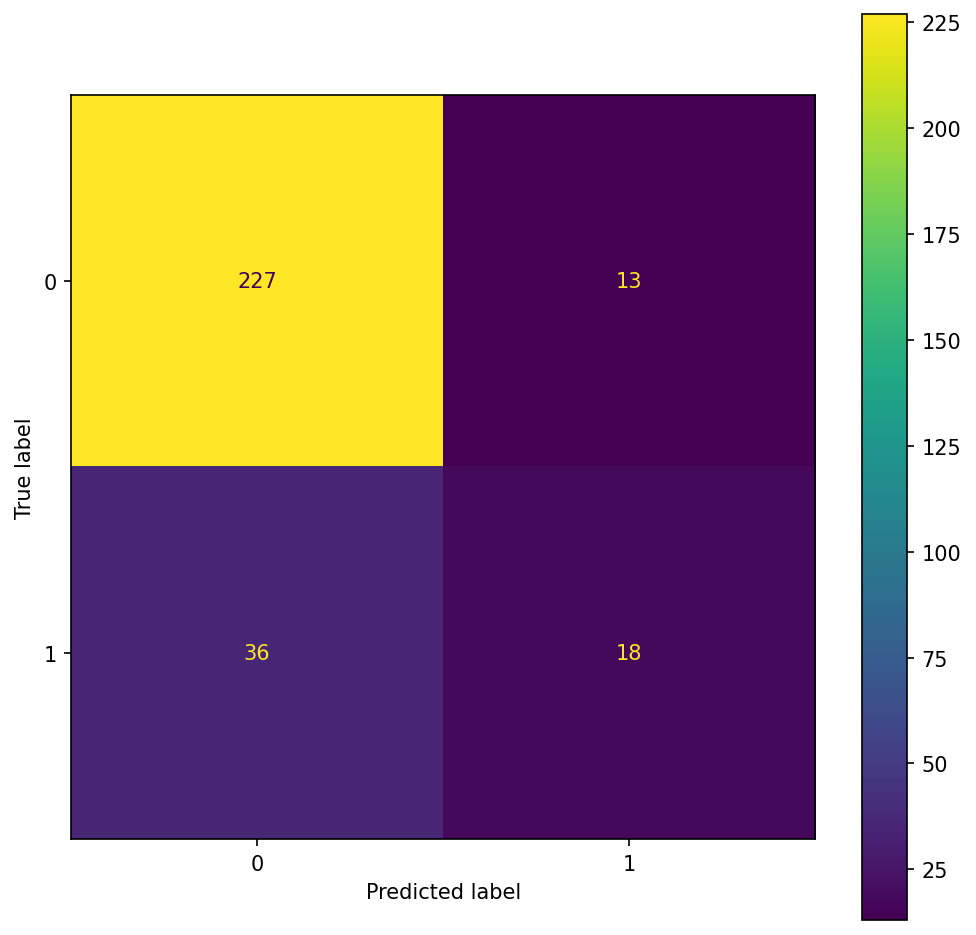

In [147]:
conf_matrix(y_test, pred_test_knn, model)

- Otimizando os hiperparâmetros com Cross-Validation e Randomized Search

In [148]:
knn_params = {
    'n_neighbors' : [3, 5, 7],
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance'],
}

In [149]:
random_search_knn = RandomizedSearchCV(model, param_distributions=knn_params, n_iter=5, cv=5, random_state=51, scoring='recall')

random_search_knn.fit(X_train_scaled, y_train)

print('Best parameters:', random_search_knn.best_params_)
print('Best recall:', random_search_knn.best_score_)

Best parameters: {'weights': 'distance', 'n_neighbors': 3, 'metric': 'euclidean'}
Best recall: 0.2132275132275132


- Modelo Refinado

In [150]:
random_search_knn.fit(X_train_scaled, y_train) 

pred_train_knn_refiined = random_search_knn.predict(X_train_scaled)
pred_test_knn_refined = random_search_knn.predict(X_test_scaled)

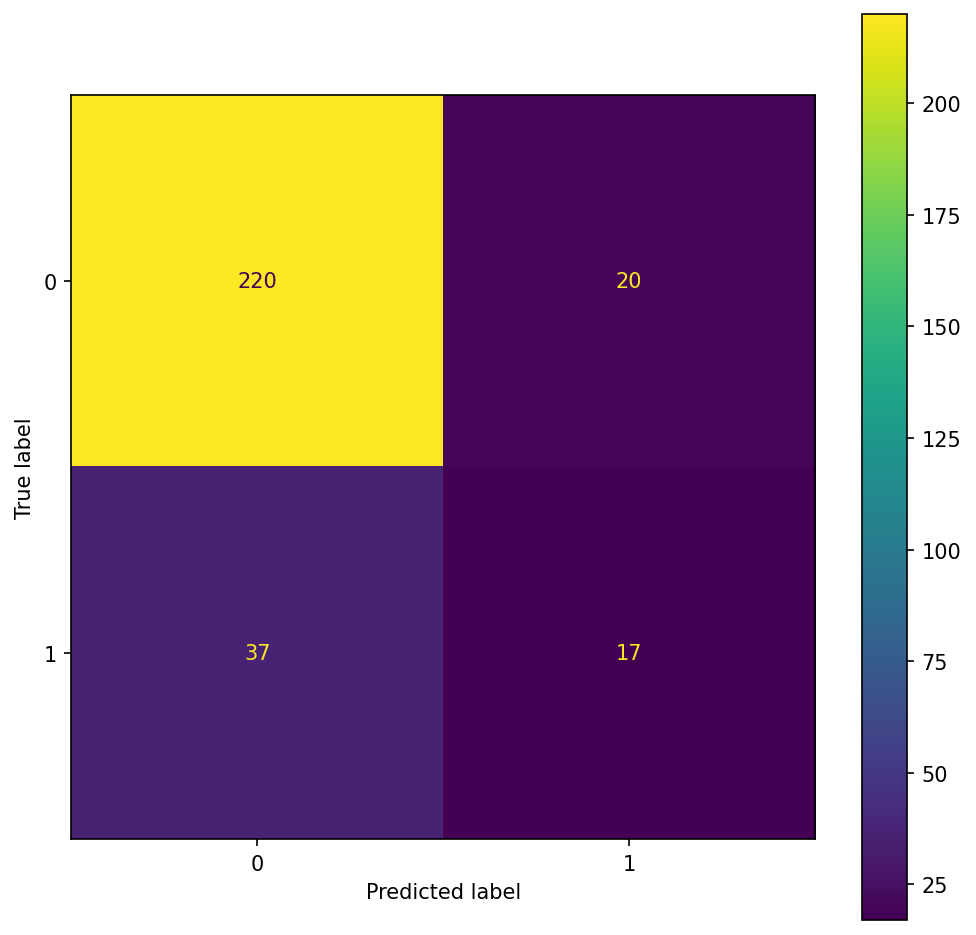

In [151]:
conf_matrix(y_test, pred_test_knn_refined, random_search_knn)

#### Comparando as matrizes de confusão dos modelos KNN

- Percebe-se que houve uma piora no modelo quando os parâmetros foram otimizados;
- Para avaliar melhor os modelos, verificou-se as métricas de recall, f1-score e precision; 
- Estamos interessados em aumentar o recall do modelo, visto que queremos minimizar o máximo possível dos falsos negativos;

In [152]:
print(f'{"Modelo Bruto":-^60}\n')
print(f'{"Train":-^60}\n{classification_report(y_train, pred_train_knn)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test_knn)}')

------------------------Modelo Bruto------------------------

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       746
           1       0.64      0.31      0.42       136

    accuracy                           0.87       882
   macro avg       0.76      0.64      0.67       882
weighted avg       0.85      0.87      0.85       882


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       240
           1       0.58      0.33      0.42        54

    accuracy                           0.83       294
   macro avg       0.72      0.64      0.66       294
weighted avg       0.81      0.83      0.81       294



In [153]:
print(f'{"Modelo Otimizado":-^60}\n')
print(f'{"Train":-^60}\n{classification_report(y_train, pred_train_knn_refiined)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test_knn_refined)}')

----------------------Modelo Otimizado----------------------

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       746
           1       1.00      1.00      1.00       136

    accuracy                           1.00       882
   macro avg       1.00      1.00      1.00       882
weighted avg       1.00      1.00      1.00       882


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       240
           1       0.46      0.31      0.37        54

    accuracy                           0.81       294
   macro avg       0.66      0.62      0.63       294
weighted avg       0.78      0.81      0.79       294



- Houve uma pequena melhora do modelo otimizado em termos de recall; 
- A seguir avaliou-se outras possibilidades para melhorar o desempenho do modelo de classificação e melhor avaliação das métricas

- Ajuste do limite (threshold) para separação de classes

In [39]:
y_score = random_search_knn.predict_proba(X_test_scaled)[:,1] # predict_proba retorna as probabilidades de cada entrada ser de determinada classe

- Fonte: https://towardsdatascience.com/predict-vs-predict-proba-scikit-learn-bdc45daa5972

In [40]:
p, r, thresholds = precision_recall_curve(y_test, y_score) # obtenção dos parâmetros de precisão, recall e limiares

- Fonte: https://towardsdatascience.com/predict-vs-predict-proba-scikit-learn-bdc45daa5972

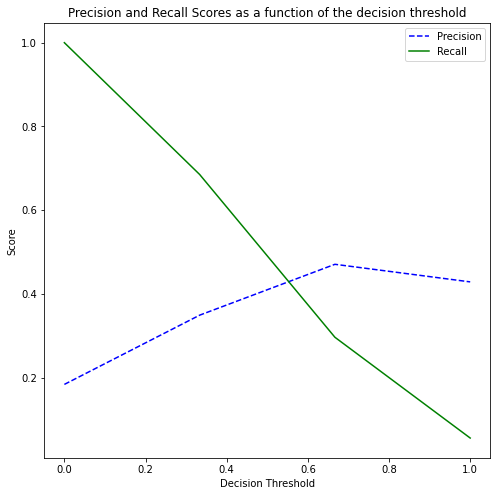

In [41]:
plot_precision_recall_vs_threshold(p, r, thresholds) # Relação da precisão e do recall para diferentes limiares de separação. 

- Fonte: https://www.ibm.com/docs/en/contentclassificatio/8.8?topic=analysis-category-graph-precision-recall-vs-threshold

- Cálculo da área abaixo da curva ROC. Quanto mais próximo de 1 melhor.

0.6395833333333333


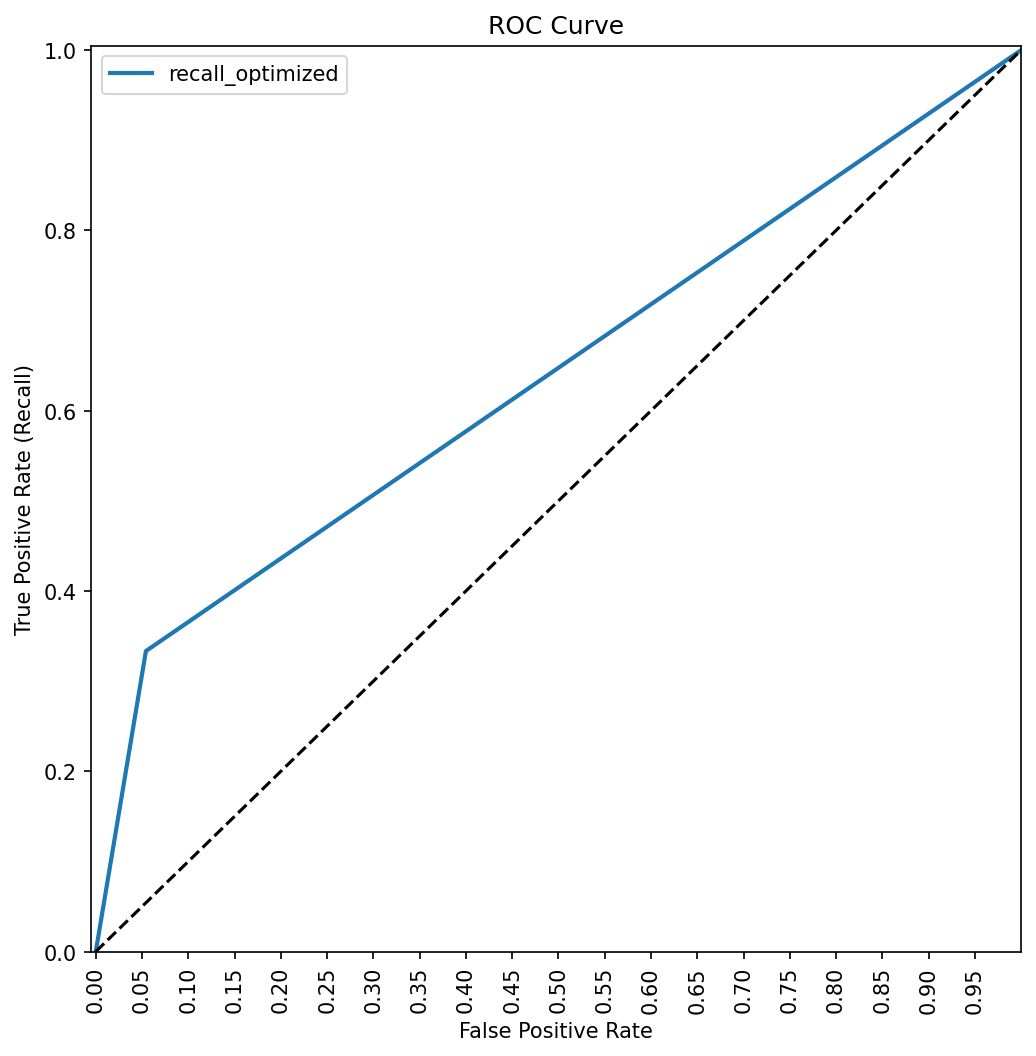

In [154]:
fpr, tpr, auc_thresholds = roc_curve(y_test, pred_test_knn)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

- Ideal seria a curva em azul

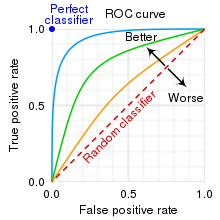

- Conclusões sobre o primeiro modelo: 
    - Há um grande desbalanceamento na variável target (84% - 0 e 16%n-n1), o que faz com que o modelo não tenha uma boa performance; 
    - Solução: Utilizar técnicas para balanceamento do dataset a fim de otimizar o desempenho do modelo

### TESTES COM DATASET BALANCEADO

In [47]:
df_balanced = pd.read_pickle('balanced_dataset.pkl')
df_balanced.head()

,age,business_travel,daily_rate,department,distance_from_home,education,education_field,environment_satisfaction,gender,hourly_rate,job_involvement,job_level,job_role,job_satisfaction,marital_status,monthly_income,monthly_rate,num_companies_worked,over_time,percent_salary_hike,performance_rating,relationship_satisfaction,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager,attrition
0,25,2,685,Research & Development,1,3,Life Sciences,1,0,62,3,2,Manufacturing Director,3,Married,34,81,0,0,12,3,4,2,5,3,3,4,2,1,2,0
1,44,2,1376,Human Resources,1,2,Medical,2,1,91,2,3,Human Resources,1,Married,-14,22,9,0,14,3,4,1,24,1,3,20,6,3,6,1
2,27,2,135,Research & Development,17,4,Life Sciences,4,0,51,3,1,Research Scientist,3,Single,90,81,1,1,13,3,4,0,8,2,3,8,2,7,7,1
3,38,2,827,Research & Development,1,4,Life Sciences,2,0,33,4,2,Healthcare Representative,4,Single,-55,-73,0,0,13,3,3,0,10,4,2,9,7,1,8,0
4,47,2,1454,Sales,2,4,Life Sciences,4,0,65,2,1,Sales Representative,4,Single,-34,81,1,1,18,3,1,0,3,3,2,3,2,1,2,0


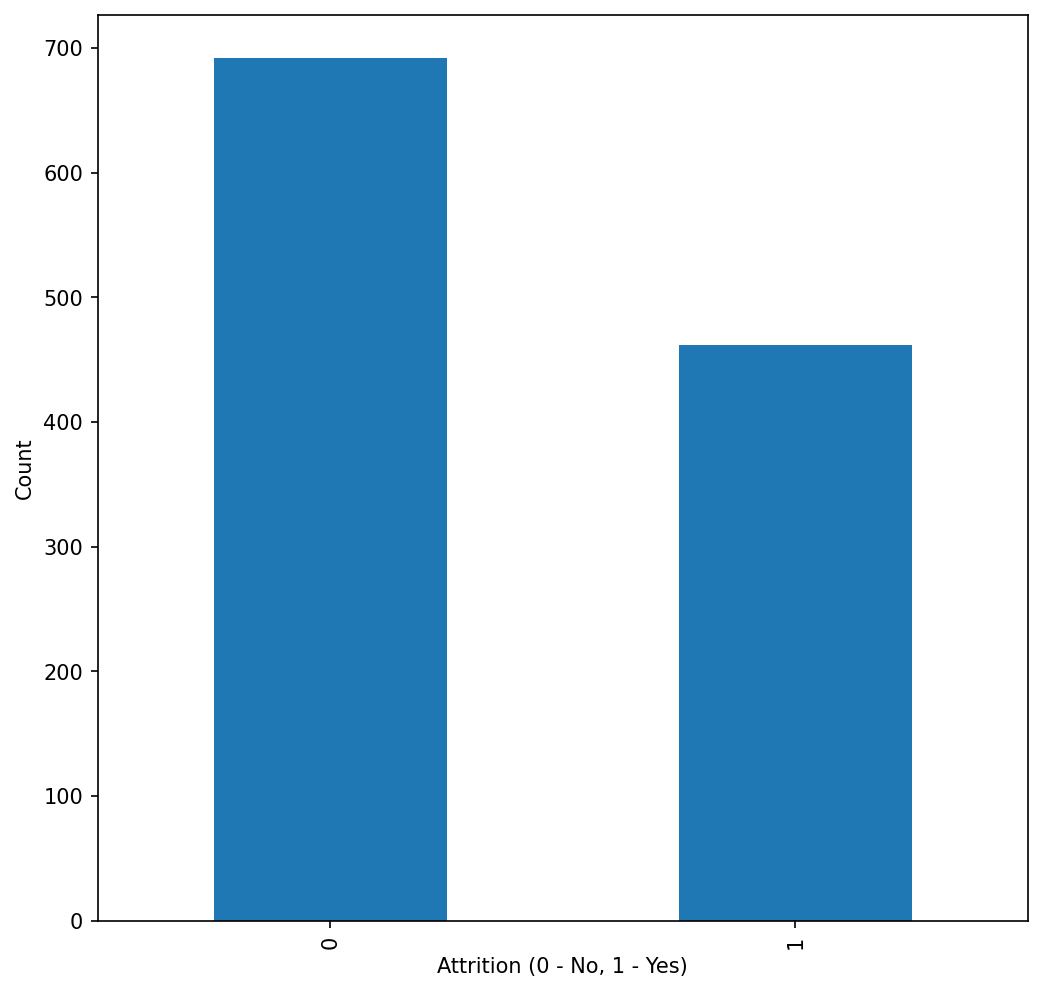

In [110]:
df_balanced.attrition.value_counts().plot(kind='bar')
plt.xlabel('Attrition (0 - No, 1 - Yes)')
plt.ylabel('Count')
plt.show()


- Pré-tratamento na variável categórica

In [59]:
df_balanced['over_time'] = df_balanced['over_time'].replace({'Yes':1, 'No':0})

- Features utilizadas, as 5 mais correlacionadas com a variável target

In [60]:
cols = ['over_time', 'job_level', 'monthly_income', 'years_at_company', 'age', 'attrition']
df_balanced = df_balanced[cols]

In [61]:
df_balanced

,over_time,job_level,monthly_income,years_at_company,age,attrition
0,0,2,34,4,25,0
1,0,3,-14,20,44,1
2,1,1,90,8,27,1
3,0,2,-55,9,38,0
4,1,1,-34,3,47,0
...,...,...,...,...,...,...
1149,1,2,-77,2,32,1
1150,0,1,73,1,26,1
1151,1,1,110,1,20,1
1152,1,3,85,16,36,1


In [155]:
X = df_balanced.drop('attrition', axis=1)
y = df_balanced.attrition

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=51)

In [157]:
print('Training set shape: ', X_train.shape, y_train.shape)
print('Testing set shape: ', X_test.shape, y_test.shape)

Training set shape:  (773, 5) (773,)
Testing set shape:  (381, 5) (381,)


In [158]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
scaler.fit(X_test)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [159]:
model = KNeighborsClassifier()
model.fit(X_train_scaled, y_train) 

KNeighborsClassifier()

In [160]:
pred_train_knn = model.predict(X_train_scaled)
pred_test_knn = model.predict(X_test_scaled)

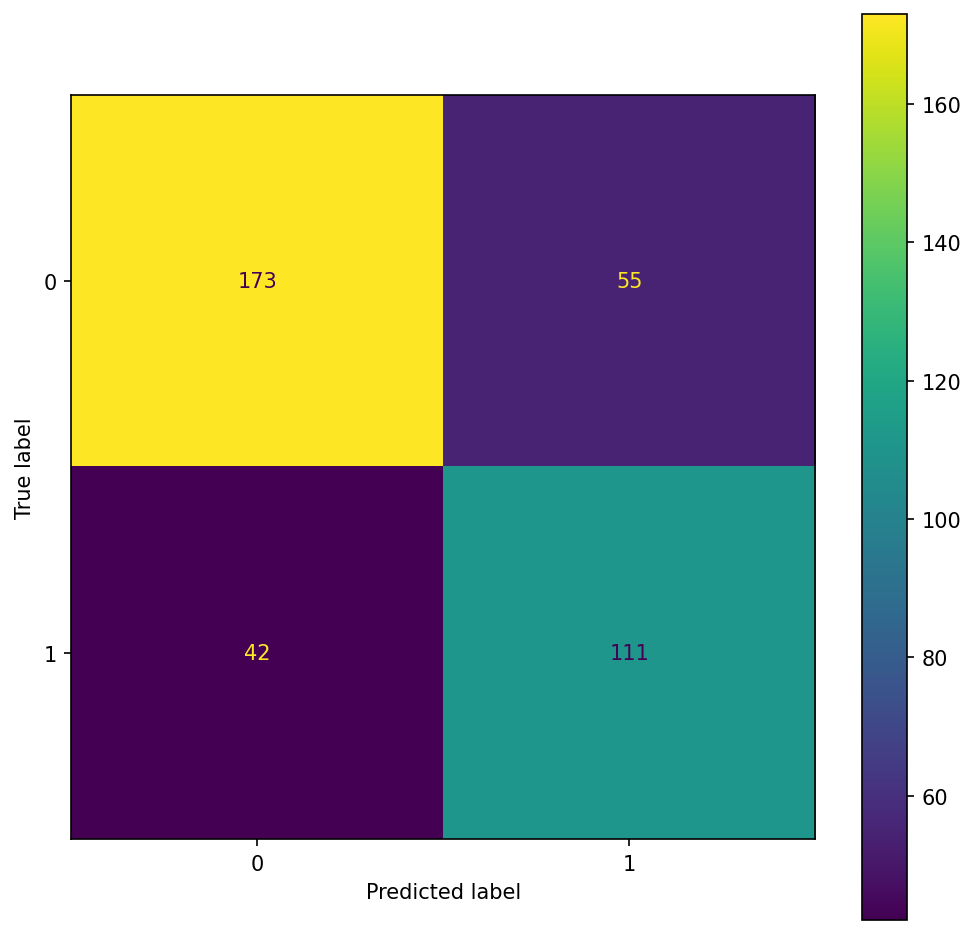

In [161]:
conf_matrix(y_test, pred_test_knn, model)

In [162]:
print(f'{"Modelo Bruto":-^60}\n')
print(f'{"Train":-^60}\n{classification_report(y_train, pred_train_knn)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test_knn)}')

------------------------Modelo Bruto------------------------

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       464
           1       0.77      0.84      0.80       309

    accuracy                           0.84       773
   macro avg       0.83      0.84      0.83       773
weighted avg       0.84      0.84      0.84       773


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       228
           1       0.67      0.73      0.70       153

    accuracy                           0.75       381
   macro avg       0.74      0.74      0.74       381
weighted avg       0.75      0.75      0.75       381



In [163]:
knn_params = {
    'n_neighbors' : [3, 5, 7],
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance'],
}

In [164]:
random_search_knn = RandomizedSearchCV(model, param_distributions=knn_params, n_iter=10, cv=5, random_state=51, scoring='recall')

random_search_knn.fit(X_train_scaled, y_train)

print('Best parameters:', random_search_knn.best_params_)
print('Best recall:', random_search_knn.best_score_)

Best parameters: {'weights': 'distance', 'n_neighbors': 3, 'metric': 'euclidean'}
Best recall: 0.8770491803278688


In [165]:
random_search_knn.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions={'metric': ['euclidean', 'manhattan'],
                                        'n_neighbors': [3, 5, 7],
                                        'weights': ['uniform', 'distance']},
                   random_state=51, scoring='recall')

In [166]:
pred_train_knn_b = random_search_knn.predict(X_train_scaled)
pred_test_knn_b = random_search_knn.predict(X_test_scaled)

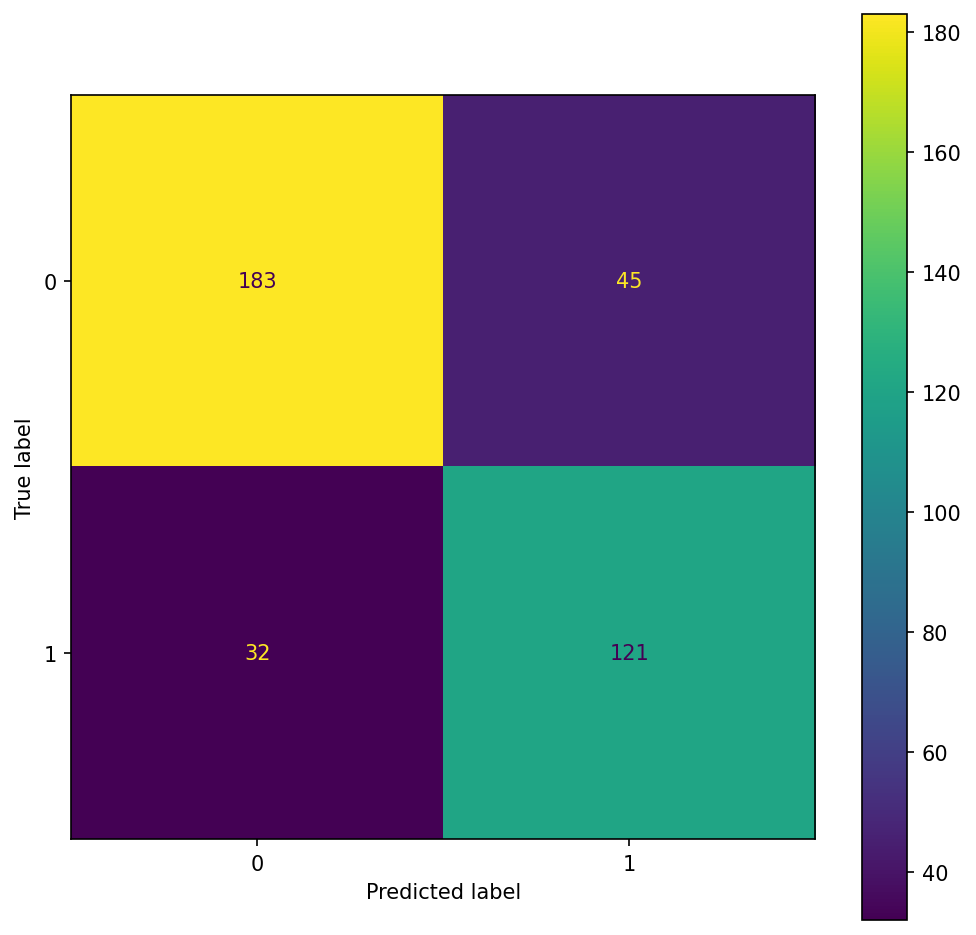

In [167]:
cm = confusion_matrix(y_test, pred_test_knn_b, labels=random_search_knn.classes_)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_search_knn.classes_)
disp2.plot()

In [168]:
print(f'{"Modelo Otimizado":-^60}\n')
print(f'{"Train":-^60}\n{classification_report(y_train, pred_train_knn_b)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test_knn_b)}')

----------------------Modelo Otimizado----------------------

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       464
           1       1.00      1.00      1.00       309

    accuracy                           1.00       773
   macro avg       1.00      1.00      1.00       773
weighted avg       1.00      1.00      1.00       773


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.85      0.80      0.83       228
           1       0.73      0.79      0.76       153

    accuracy                           0.80       381
   macro avg       0.79      0.80      0.79       381
weighted avg       0.80      0.80      0.80       381



0.7967406260749912


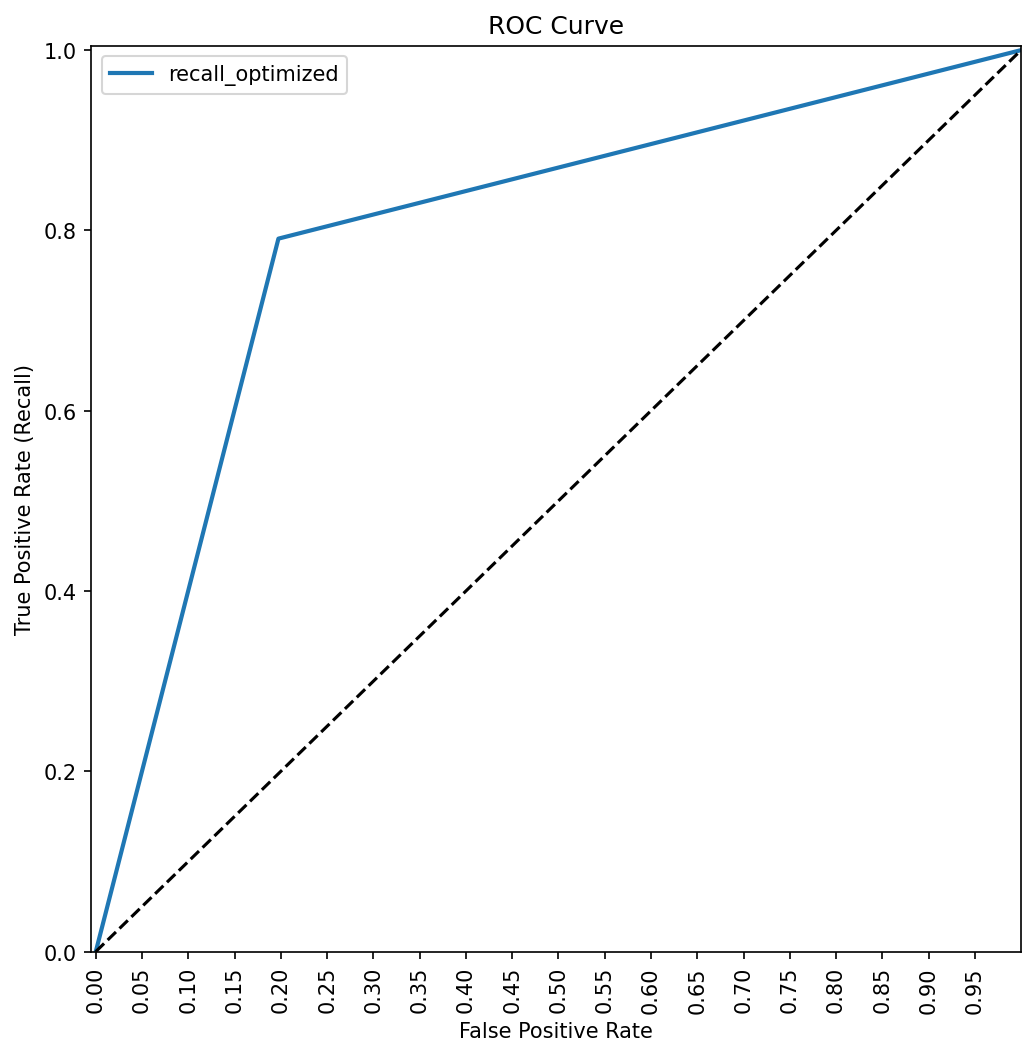

In [169]:
fpr, tpr, auc_thresholds = roc_curve(y_test, pred_test_knn_b)

print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')


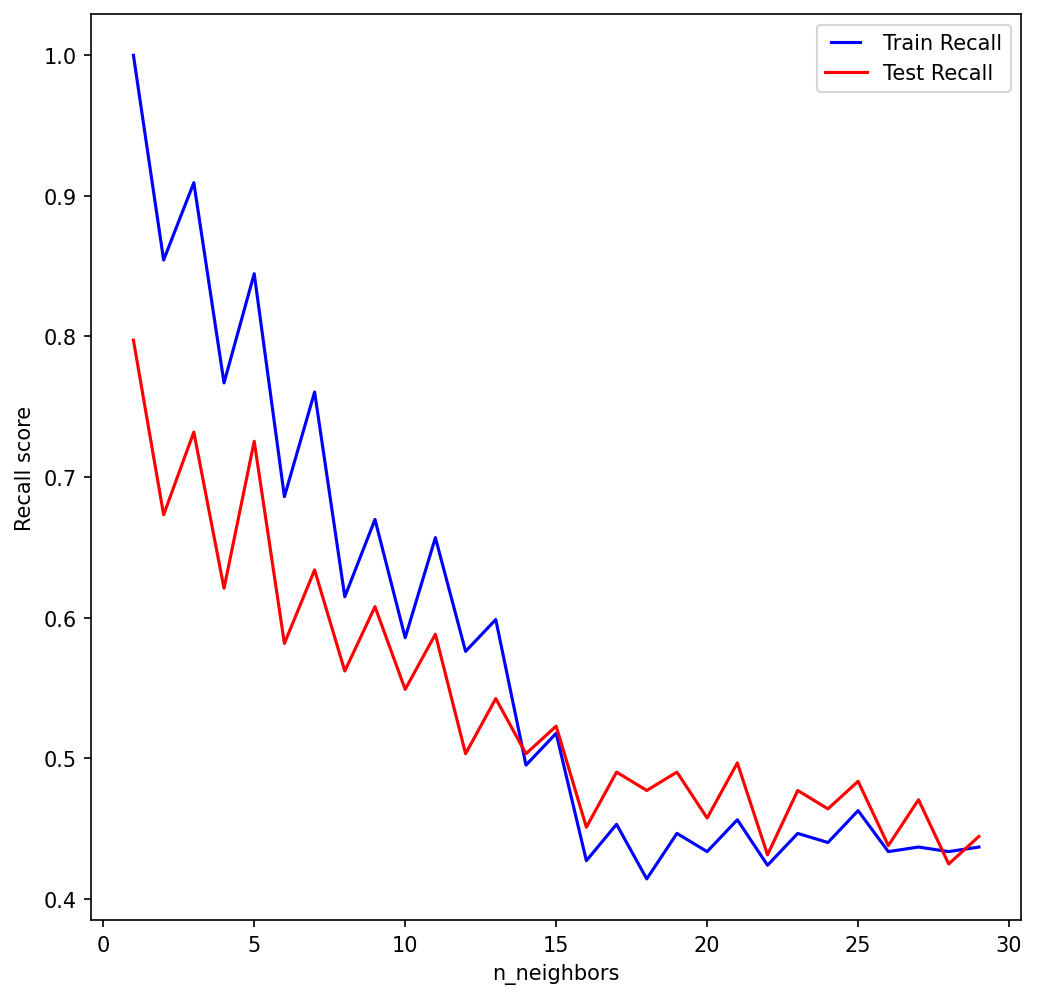

In [177]:
neighbors = list(range(1,30))
train_results = []
test_results = []
for n in neighbors:
   model = KNeighborsClassifier(n_neighbors=n)
   model.fit(X_train_scaled, y_train)
   train_pred = model.predict(X_train_scaled)
   recall_train = recall_score(y_train, train_pred)
   train_results.append(recall_train)
   y_pred = model.predict(X_test_scaled)
   recall_test = recall_score(y_test, y_pred)
   test_results.append(recall_test)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(neighbors, train_results, 'b', label='Train Recall')
line2, = plt.plot(neighbors, test_results, 'r', label='Test Recall')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Recall score')
plt.xlabel('n_neighbors')
plt.show()

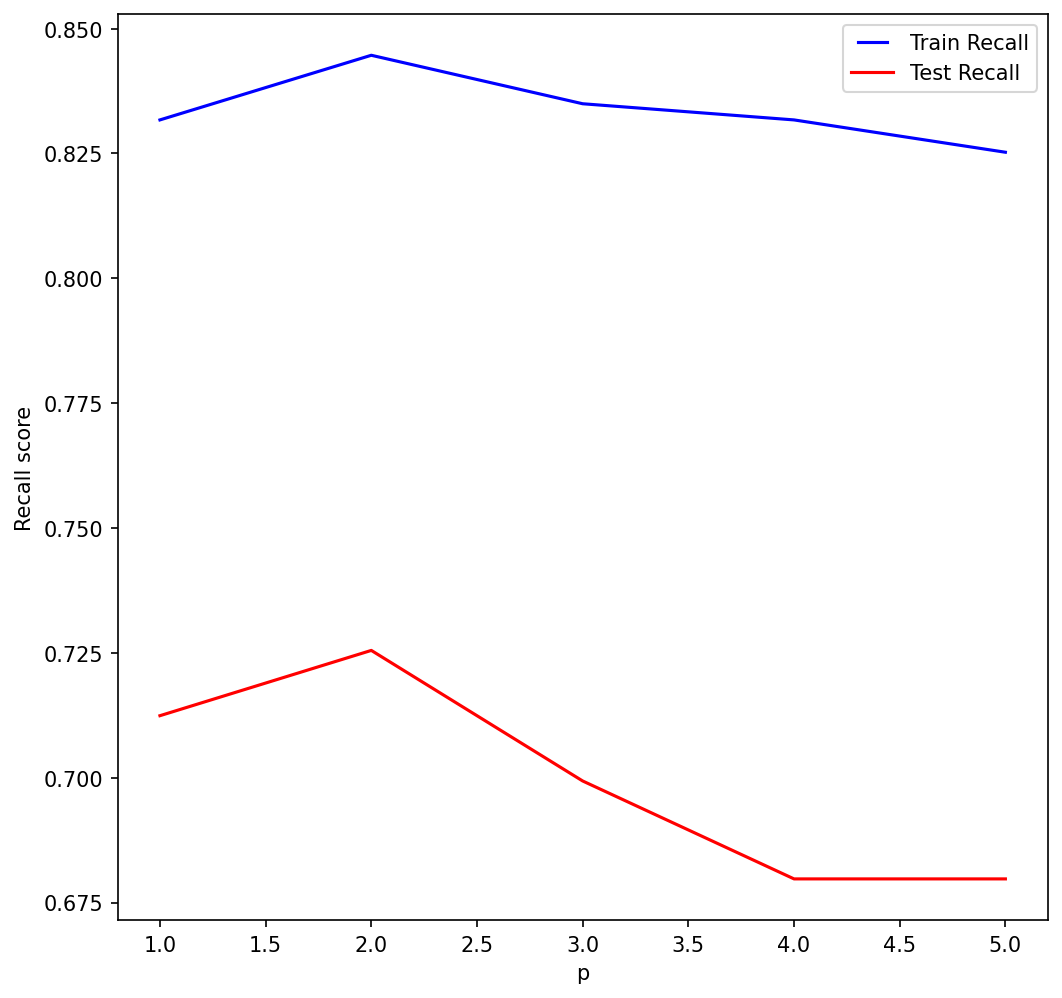

In [178]:
distances = [1, 2, 3, 4, 5]
train_results = []
test_results = []
for p in distances:
   model = KNeighborsClassifier(p=p)
   model.fit(X_train_scaled, y_train)
   train_pred = model.predict(X_train_scaled)
   recall_train = recall_score(y_train, train_pred)
   train_results.append(recall_train)
   y_pred = model.predict(X_test_scaled)
   recall_test = recall_score(y_test, y_pred)
   test_results.append(recall_test)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(distances, train_results, 'b', label='Train Recall')
line2, = plt.plot(distances, test_results, 'r', label='Test Recall')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Recall score')
plt.xlabel('p')
plt.show()

### Random Forest 

In [113]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=51)

forest.fit(X_train, y_train)

pred_train_rf = forest.predict(X_train)
pred_test_rf = forest.predict(X_test)

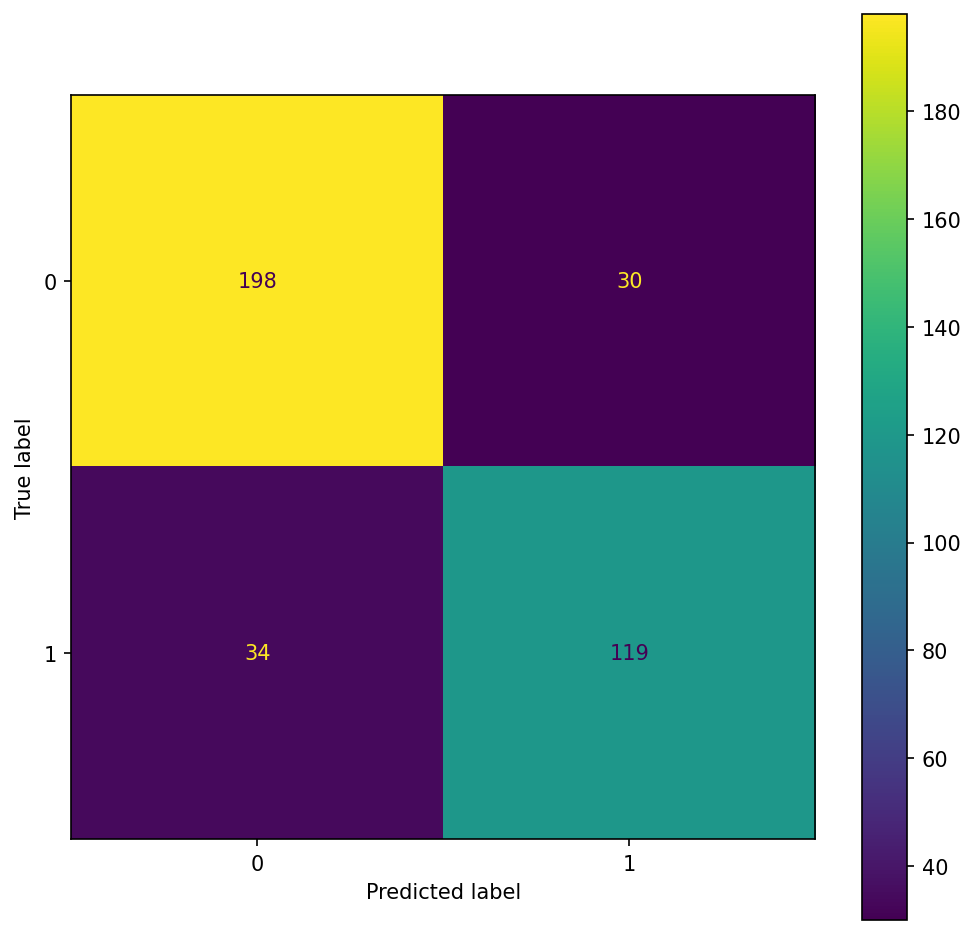

In [114]:
cm = confusion_matrix(y_test, pred_test_rf, labels=forest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=forest.classes_)
disp.plot()

In [115]:
print(f'{"Modelo Bruto":-^60}\n')
print(f'{"Train":-^60}\n{classification_report(y_train, pred_train_rf)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test_rf)}')

------------------------Modelo Bruto------------------------

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       464
           1       1.00      1.00      1.00       309

    accuracy                           1.00       773
   macro avg       1.00      1.00      1.00       773
weighted avg       1.00      1.00      1.00       773


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       228
           1       0.80      0.78      0.79       153

    accuracy                           0.83       381
   macro avg       0.83      0.82      0.82       381
weighted avg       0.83      0.83      0.83       381



- O modelo overfitou, a seguir, serão realizados testes para limitar o modelo e evitar o overfiting

In [203]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 30, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [1,2,3,4]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
grid_params_rf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [204]:
random_search = RandomizedSearchCV(forest, param_distributions=grid_params_rf, n_iter=10, cv=5, random_state=51, scoring='recall')

random_search.fit(X_train, y_train)

print('Best parameters:', random_search.best_params_)
print('Best recall:', random_search.best_score_)

Best parameters: {'n_estimators': 27, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Best recall: 0.8024854574299314


In [205]:
rf_optimal_train = random_search.predict(X_train)
rf_optimal_test = random_search.predict(X_test)

In [206]:
print(f'{"Modelo Bruto":-^60}\n')
print(f'{"Train":-^60}\n{classification_report(y_train, rf_optimal_train)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, rf_optimal_test)}')

------------------------Modelo Bruto------------------------

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       464
           1       0.99      0.97      0.98       309

    accuracy                           0.98       773
   macro avg       0.98      0.98      0.98       773
weighted avg       0.98      0.98      0.98       773


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       228
           1       0.78      0.74      0.76       153

    accuracy                           0.81       381
   macro avg       0.80      0.80      0.80       381
weighted avg       0.81      0.81      0.81       381



0.7991056071551428


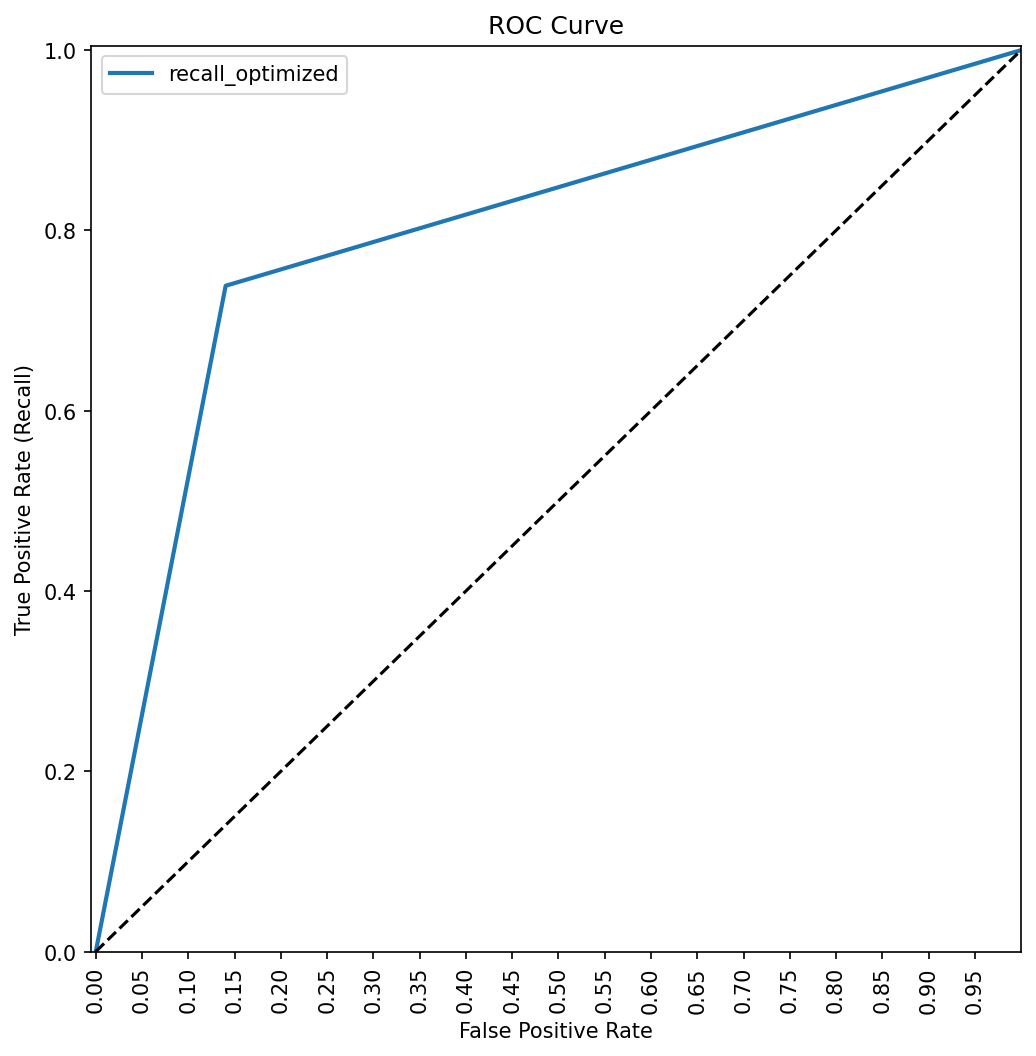

In [207]:
fpr, tpr, auc_thresholds = roc_curve(y_test, rf_optimal_test)

print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

#### LOGISTIC REGRESSION

In [122]:
log = LogisticRegression()
log.fit(X_train, y_train)

pred_train_log = log.predict(X_train)
pred_test_log = log.predict(X_test)

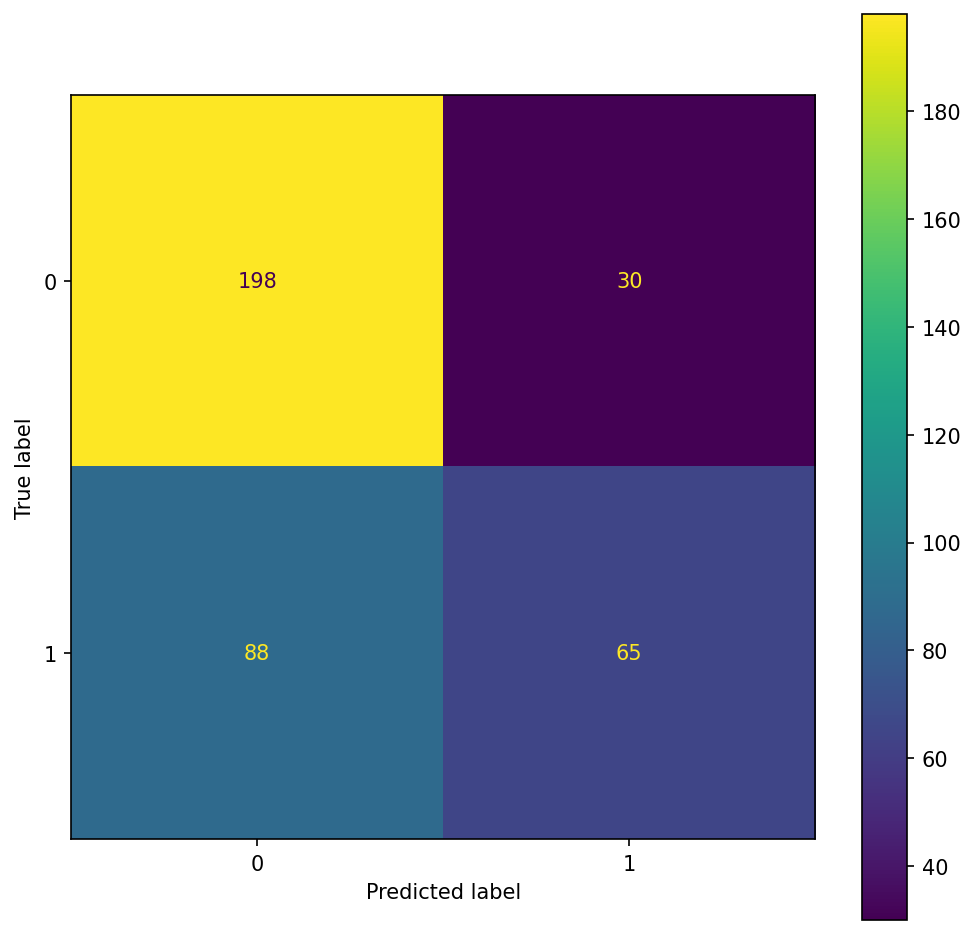

In [123]:
conf_matrix(y_test, pred_test_log, log)

In [124]:
print(f'{"Modelo Bruto":-^60}\n')
print(f'{"Train":-^60}\n{classification_report(y_train, pred_train_log)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test_log)}')

------------------------Modelo Bruto------------------------

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.70      0.84      0.77       464
           1       0.66      0.46      0.54       309

    accuracy                           0.69       773
   macro avg       0.68      0.65      0.65       773
weighted avg       0.68      0.69      0.68       773


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.69      0.87      0.77       228
           1       0.68      0.42      0.52       153

    accuracy                           0.69       381
   macro avg       0.69      0.65      0.65       381
weighted avg       0.69      0.69      0.67       381



#### Conclusões

- Melhor modelo foi o KNN bruto. Com recall de 0.77 no conjunto de teste; 
- O KNN otimizado overfitou, precisa de ajuste;
- Random Forest otimizado apresentou resultados semelhantes ao KNN bruto;
- Logistic Regression foi o que obteve pior performance, talvez precise de mais dados; 